## Взаимосвязь топливной ренты и эскалации вооруженных конфликтов с участием нефтедобывающих стран

In [1]:
from statsmodels.discrete.count_model import ZeroInflatedNegativeBinomialP,ZeroInflatedPoisson,ZeroInflatedGeneralizedPoisson
from statsmodels.discrete.truncated_model import HurdleCountModel
from statsmodels.iolib.summary2 import summary_col
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.tools as sm
from lifelines import CoxTimeVaryingFitter

import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis, norm, chi2
from scipy.special import expit

import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *

np.random.seed(101)

### Исследовательская проблема и исследовательский вопрос


Проблема настоящего исследования состоит в том, что в литературе по ресурсному проклятию имеется следующая лакуна: очень большое внимание уделяется роли нефтяных богатств как таковых в эскалации гражданских и межгосударственных конфликтов, однако в тени остается вопрос о различиях в вовлеченности нефтедобывающих стран в такие конфликты; что если непредвиденные доходы от продажи нефти создают разнонаправленные конфликтные стимулы, способные склонять к эскалации конфликтного поведения одни страны и предохранять от нее другие страны? Словом, в настоящем исследовании мы попытаемся частично восполнить пробел, связанный с недостатком внимания к различиям в нефтедобывающих странах, способных в той или иной мере определять характер их внешней политики.

Исходя из этого исследовательский вопрос настоящей работы можно сформулировать следующим образом: 

    «Какова роль иностранных компаний, действующих в нефтедобывающей отрасли страны, во взаимосвязи топливной ренты и эскалации вооруженных конфликтов с участием нефтедобывающих стран?»

Основная гипотеза исследования состоит в том, что присутствие иностранных компаний в нефтедобывающей отрасли оказывает «сдерживающий» эффект на процесс эскалации вооруженных конфликтов с участием нефтедобывающей страны, в которой они занимаются разведкой и добычей нефти.


В рамках исследования мы сосредоточим внимание только на тех странах, которых можно охарактеризовать, как зависимые от нефти. Причина этого состоит в том, что колебания цены на нефть в наибольшей мере отразятся на тех странах, в которых добыча нефти занимает значительное место в экономике. В связи с этим мы ограничиваем выборку странами, в которых:

1) топливная рента составляет не менее 10% ВВП страны
2) топливная рента составляет не менее 15% ВВП страны
3) доля экспорта нефти составляет не менее 50% от общего экспорта страны

In [112]:
df = pd.read_csv(r'C:\Users\ESolodov\Desktop\mine\df_res\rent10_sample.csv')

Краткий обзор переменных:

* *MIE(2)* - число милитаризованных межгосударственных событий, инициированных страной (не ниже второго уровня, т.е. угрозы применения силы)
* *MIE(4)* - число милитаризованных межгосударственных событий, инициированных страной (не ниже четвертого уровня, т.е. применения силы)
* *MIE(2)_against* - число милитаризованных межгосударственных событий, инициированных против страны (не ниже второго уровня, т.е. угрозы применения силы)
* *MIE(4)_against* - число милитаризованных межгосударственных событий, инициированных против страны (не ниже четвертого уровня, т.е. применения силы)
* *OilPrice* - средняя годовая цена на нефть марки Arab Light или Brent за баррель в постоянных долларах США за 2023 г.
* *LagOilPrice* - лагированная $(t - 1)$ средняя годовая цена на нефть марки Arab Light или Brent за баррель в постоянных долларах США за 2023 г.
* *OilPriceAvg.3* - средняя скользящая цена на нефть марки Arab Light или Brent за баррель в постоянных долларах США за 2023 г. в трехлетний период
* *OilPriceAvg.5* - средняя скользящая цена на нефть марки Arab Light или Brent за баррель в постоянных долларах США за 2023 г. в пятилетний период
* *Democracy* - индекс демократии (V-dem)
* *LogGDPPC* - ВВП на душу населения
* *OilProduction* - объем добычи нефти
* *ForComp* - режим собственности в нефтедобывающей отрасли, который характеризуется преобладанием иностранных компаний
* *RevolLeader* - революционный лидер или правительство
* *Rivalries* - число стратегических соперничеств (долгосрочные и устойчивые отношения конкуренции между государствами)
* *Rebels* - число оппозиционных движений, действующих на территории страны
* *Allies* - число военных союзников страны
* *USTroops* - численность американского военного контингента, развернутого на территории страны

Подробнее с описанием и источниками переменных можно ознакомиться в тексте исследования.

In [113]:
df = pd.DataFrame({
    'Country' : df['StateNme'],
    'Year' : df['year'],
    'MIE(2)' : df['mie(2)'],
    'MIE(4)' : df['mie(4)'],
    'MIE(2)_against' : df['mie(2)_against'],
    'MIE(4)_against' : df['mie(4)_against'],
    'OilPrice' : df['price'],
    'LagOilPrice' : df['lagged'],
    'OilPriceAvg.3' : df['roll_mean3'],
    'OilPriceAvg.5' : df['roll_mean5'],
    'Democracy' : df['v2x_polyarchy'],
    'LogGDPPC' : df['log_gdppc'],     
    'OilProduction' : df['prod_yj'],
    'ForComp' : df['for_priv'],
    'RevolLeader' : df['revolutionaryleader'],
    'Rivalries' : df['riv'],
    'Allies' : df['number'],
    'Rebels' : df['rebels'],
    'USTroops' : df['troops_yj']
})

### Предварительный анализ

Зависимая переменная в анализе - число милитаризованных межгосударственных событий, ининициированных нефтедобывающей страной (или против нее) в течение конкретного года наблюдения.

Посмотрим на распределение значений (можно догадаться, что оно не будет соответствовать нормальному распределению, поскольку переменная принимает только неотрицательные дискретные значения). Значение метрики `skewness` $(> 0)$ указывает на то, что распределение скошенно вправо (посмотрим на правосторонний хвост на гистограмме), значение метрики `kurtosis` $(> 3)$ указывает на то, что распределение имеет острую вершину.

Skewness is 6.110204046911134
Kurtosis is 52.32411378661779


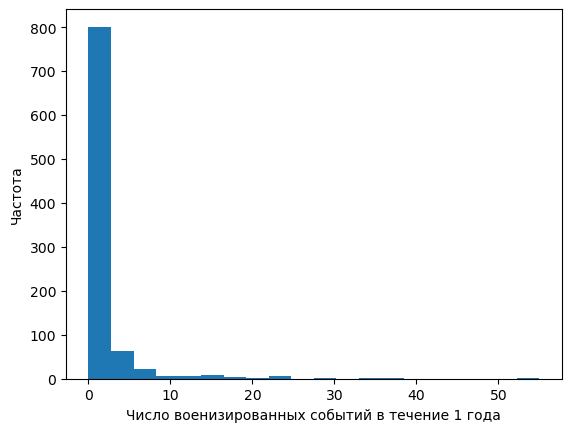

In [114]:
print(f'Skewness is {skew(df['MIE(2)'], axis=0, bias=True)}')
print(f'Kurtosis is {kurtosis(df['MIE(2)'], axis=0, bias=True)}')

plt.hist(df['MIE(2)'],bins=20);
plt.ylabel('Частота')
plt.xlabel('Число военизированных событий в течение 1 года')
plt.show()

Важно понимать, что в случае работы со счетными данными аппроксимация непрерывным распределением оказывается неудовлетворительной, что существенно влияет на адекватность регрессии с использованием МНК. Если счетные данные характеризуются гетерогенностью (т.е. в большинстве случаев наблюдается нулевое значение, реже — единичные экземпляры, и лишь изредка — их скопления) и не имеют фиксированного верхнего предела, то целесообразно использовать распределение Пуассона.

**Распределение Пуассона** $P(\lambda)$ описывает случайную величину $Y$, отражающую количество событий, происходящих за фиксированный интервал времени, при условии их независимости и постоянной интенсивности $\lambda > 0$. Математическое ожидание и дисперсия равны $\mathbb{E}(Y) = \lambda$ и $\text{Var}(Y) = \lambda$. Функция вероятности задается формулой:

$$ P(Y=k) = \frac{e^{-\lambda}\lambda^k}{k!}, k = 0,1,2,...n$$

Регрессия Пуассона применяется, когда зависимая переменная $Y$ является счетной. Модель имеет следующий вид

$$ \ln(\lambda) = \beta_0 + \sum^{n}_{i=1} \beta_j x_j ,$$ 

где $x_1,...,x_n $ - независимые переменные, $\beta_0$ - логарифм математического ожидания $Y$ при равенстве нулю всех предикторов $x_j$, $\beta_j$ - коэффициенты независимых переменных.

In [115]:
print(f'Среднее значение равно {np.mean(df['MIE(2)']):.2f}, дисперсия равна {np.var(df['MIE(2)']):.2f}')

Среднее значение равно 1.31, дисперсия равна 16.48


На практике для счетных данных часто возникает проблема избыточной дисперсии (overdispersion), когда $\mathbb{E}(Y) < \text{Var}(Y)$. В таких случаях альтернативами служат обобщенное распределение Пуассона и отрицательное биномиальное распределение.

**Обобщенное распределение Пуассона** $GP(\lambda,\theta)$ расширяется классический случай, вводя параметр $\theta$, который регулирует дисперсию. Функция плотности вероятности выглядит следующим образом: 

$$ P(Y = k) = \frac{\lambda(\lambda+\theta k)^{k-1}e^{-(\lambda+\theta k)}}{k!}, k=1,2,3,n, \lambda > 0, \theta > -1$$

где $\lambda$ - параметр интенсивности (базовая частота событий), а $\theta$ - параметр, управляющий дисперсией.

**Отрицательное биномиальное распределение** $NB(\mu,\theta)$ моделирует количество неудач до $\theta$-го успеха в испытаниях Бернулли. Его можно представить как смесь Гамма- и Пуассоновского распределений. Функция плотности вероятности может быть выражена следующим образом:

$$ P(Y = y) = \frac{\Gamma(y+\theta)}{\Gamma(y+1)\Gamma(\theta)} \left(\frac{\mu}{\mu + \theta}\right)^{y} \left(\frac{\theta}{\mu + \theta}\right)^{\theta}, y = 0,1,2,3,n, \mu > 0, \theta > 0$$

где $\mu$ - ожидаемое число событий, а $\theta$ - параметр, управляющий дисперсией.


In [116]:
df['MIE(2)'].value_counts(normalize=True).iloc[:5]

MIE(2)
0.0    0.727273
1.0    0.093074
2.0    0.046537
3.0    0.034632
4.0    0.020563
Name: proportion, dtype: float64

Помимо этого, при работе с счетными данными часто возникает проблема избытка нулевых значений (excess zeros). В таком случае целесообразно использовать модели с завышением нулей (Zero Inflated), которые состоят из двух компонент: логистической компоненты для моделирования вероятности того, что ноль возникает «структурно», то есть вне вероятностного механизма; и пуассоновской (или любое другое распределение из экспоненциального семейства) компоненты для моделирования процесса генерации дискретных значений, включая «случайные» нули – нули, возникающие в результате вероятностного процесса.

Действие модели можно представить так. Мы делим данные на три воображаемые группы:

1) первая группа содержит только «структурные» нули (можно думать о них, как о «ложных» нулях) - наблюдения с вероятностью появления $P_{Logit}$;
2) вторая группа содержит только «случайные» нули (можно думать о них, как об «истинных» нулях) - наблюдения с вероятностью появления $P_{Logit} - 1$;
3) третья группа содержит ненулевые значения, которые вместе со «случайными» нулями моделируются распределением Пуассона.

Тогда распределение вероятностей по модели определяется следующими выражениями: 

$$ P(Y_i=0) = P_{Logit} + (1 - P_{Logit}) \times P_{Pois}(Y_i=0|\lambda,\theta)$$
$$ P(Y_i = y_i | y_i > 0) = (1 - P_{Logit}) \times P_{Pois}(Y_i = y_i | \lambda,\theta)$$

Таким образом, первая компонента - это система «выключение-выключение», которая моделирует бинарный процесс. Система «выключена» с вероятностью $P_{Logit}$ и «включена» с вероятностью $1-P_{Logit}$. Когда система «выключена», возможен только нулевой подсчет; когда система «включена», выполняется подсчет дискретных значений (включая нули).

    Пример Zero Inflated модели: производитель автомобилей хочет сравнить две программы контроля качества своих автомобилей. Они будут сравниваться на основе количества поданных претензий по гарантии. При этом извествно, что некоторые ремонтные работы на автомобилях проводятся без предъявления претензии по гарантии. Таким образом, нулевые значения отражают как отсутствие проблем с контролем качества, так и наличие проблем с контролем качества, которые не сопровождались претензиями по гарантии. Состояние "выключено" означает "не подано ни одной заявки", в то время как состояние "включено" означает "подана хотя бы одна заявка или был произведен ремонт без подачи заявки".

Теперь давайте построим диаграмму рассеяния с зависимой переменной `MIE(2)` и независимой переменной `OilPrice`. В целом, мы можем сказать, что между переменными нет какой-либо взаимосвязи. Однако подтверждение или опровержение наличия взаимосвязи между ценой на нефть и эскалацией вооруженных конфликтов не является ключевым вопросом настоящего исследования. Мы хотим посмотреть на то, различается ли эта взаимосвязь в странах, в которых иностранные компании широко представлены в нефтедобывающей отрасли, и в странах, в которых в нефтедобывающей отрасли преобладают государственные или частные национальные компании.

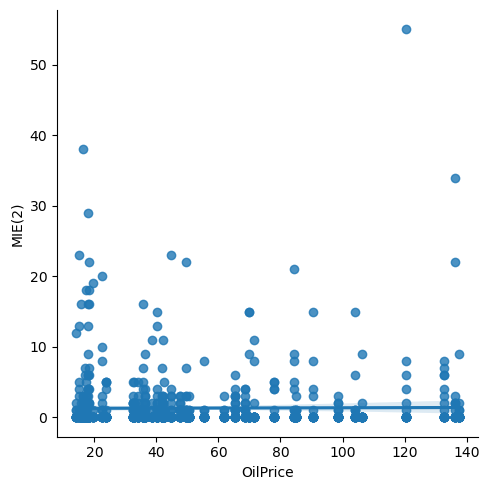

In [117]:
sns.lmplot(data=df,x='OilPrice',y='MIE(2)');

Для этого мы построим еще одну диаграмму рассеяния, на которой отделим взаимосвязь зависимой и независимой переменных в первых и во вторых странах. Однако снова мы не обнаруживаем устойчивой взаимосвязи ни в одной из групп стран.

Тем не менее на графике мы можем заметить кое-что интересное. Практически все оранжевые точки (за исключением нескольких в левом нижнем углу) сконцентрированы вдоль оси $y = 0$, тогда как синие точки распределены по всей площади графика. Это может указывать на то, что страны из оранжевой группы (`ForComp` = 1) при любых ценах на нефть (возможно, за исключением совсем низких) не склонны инициировать военизированные события.

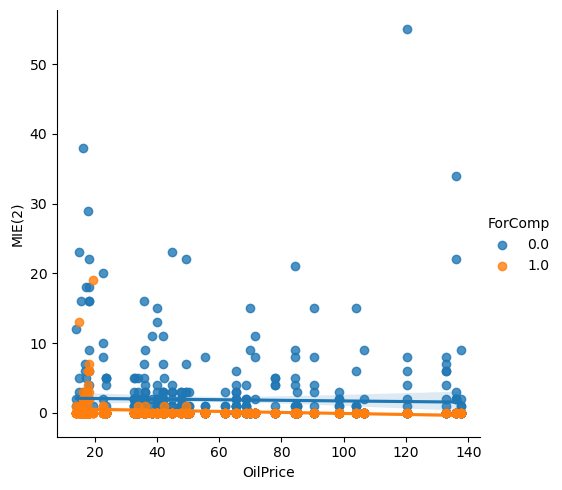

In [118]:
sns.lmplot(data=df,x='OilPrice',y='MIE(2)',hue='ForComp',ci=95);

Теперь построим диаграмму рассеяния, где в качестве зависимой переменной используем `MIE(2)_against` - число милитаризованных межгосударственных событий, инициированных против нефтедобывающей страны. В этом случае мы не обнаруживаем даже незначительной взаимосвязи между зависимой и независимой переменными. Однако опять же практически все оранжевые точки сконцентрированы вдоль оси $y = 0$, тогда как синие распределены по всей площади графика.

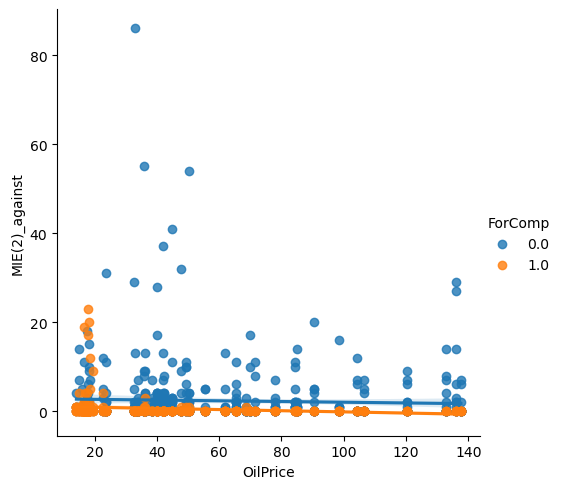

In [119]:
sns.lmplot(data=df,x='OilPrice',y='MIE(2)_against',hue='ForComp',ci=95);

### Эмпирические гипотезы

* **Гипотеза 1.** Присутствие иностранных компаний в нефтедобывающей отрасли связано с ослаблением взаимосвязи топливной ренты и эскалации вооруженных конфликтов, инициированных нефтедобывающими странами.
* **Гипотеза 2.** Присутствие иностранных компаний в нефтедобывающей отрасли связано с ослаблением взаимосвязи топливной ренты и эскалации вооруженных конфликтов, инициированных против нефтедобывающих стран.
* **Гипотеза 3.** Присутствие иностранных компаний в нефтедобывающей отрасли связано с большим риском завершения вооруженного конфликта, инициированного нефтедобывающей страной.
* **Гипотеза 4.** Присутствие иностранных компаний в нефтедобывающей отрасли связано с большим риском завершения вооруженного конфликта, инициированного в отношении нефтедобывающей страны.

### Тестирование Гипотезы 1

#### Zero Inflated Generalized Poisson

In [120]:
data = df[[
    'Country',
    'Year',
    'MIE(2)',
    'OilPrice',
    'LogGDPPC',
    'OilProduction',
    'Democracy',
    'RevolLeader',
    'Allies',
    'USTroops',
    'Rivalries',
    'Rebels',
    'ForComp'
]].dropna()

data['Interaction'] = data['OilPrice']*data['ForComp']

y = data['MIE(2)']
X = data.drop(columns=['MIE(2)','Country','Year'])
X = sm.add_constant(X)

m_zigp = ZeroInflatedGeneralizedPoisson(y,X,X)
m_zigp = m_zigp.fit(maxiter=10000,cov_type='HC3',method='lbfgs')
print(m_zigp.summary())

                    ZeroInflatedGeneralizedPoisson Regression Results                     
Dep. Variable:                             MIE(2)   No. Observations:                  635
Model:             ZeroInflatedGeneralizedPoisson   Df Residuals:                      623
Method:                                       MLE   Df Model:                           11
Date:                            Sat, 17 May 2025   Pseudo R-squ.:                  0.1810
Time:                                    02:28:52   Log-Likelihood:                -714.53
converged:                                   True   LL-Null:                       -872.39
Covariance Type:                              HC3   LLR p-value:                 4.238e-61
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
inflate_const             1.2109      0.803      1.508      0.132      -0.363       2.785
in

В регрессионной выдачи можно обнаружить коэффициенты логистической компоненты (они имеют префикс inflate_) и коэффициенте пуассоновской компоненты. Далее мы остановится на второй компоненте.

Для простоты интерпретации мы можем построить график предельного эффекта цены на нефть на ожидаемое число милитаризованных межгосударственных конфликтов, инициированных страной, в зависимости от институциональных условий доступа к ренте.

Мы можем видить, что в странах, в которых иностранные компании представлены в нефтедобывающей отрасли, с ростом цены на нефть связано уменьшение интенсивности конфликта. В странах, в нефтедобывающей отрасли которых представлены национальные компании, напротив, рост цены связан с увеличением интенсивности конфликта.

Обратите внимание, что в интепретации мы использовали термин «интенсивность». Это связано с тем, что пуассоновская компонента, как мы говорили ранее, моделирует процесс генерации дискретных значений. 

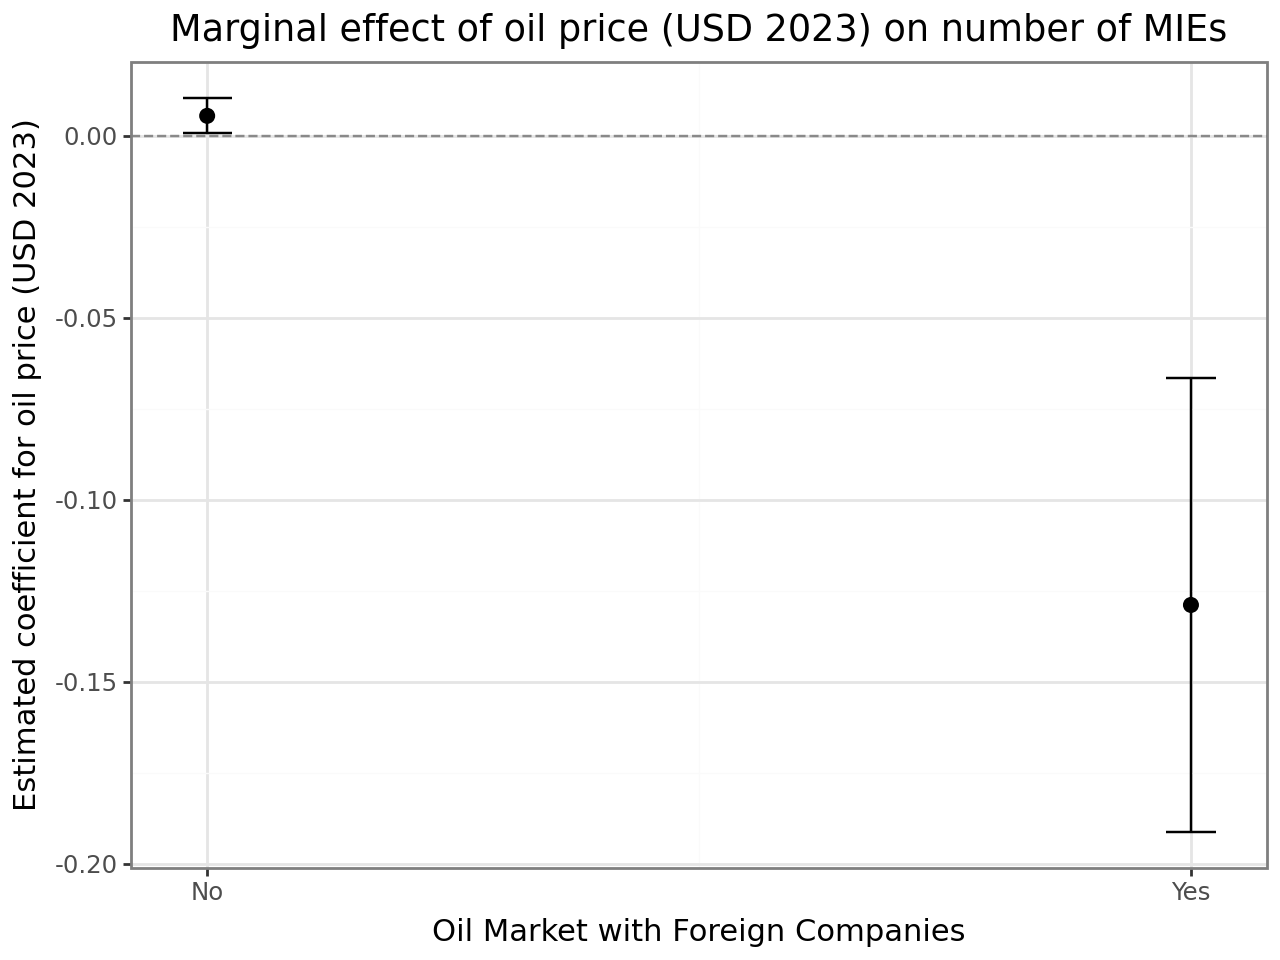

In [121]:
values = X.ForComp.unique()
merg_effect = m_zigp.params.iloc[13] + m_zigp.params.iloc[23] * values
cov_m = np.asmatrix(m_zigp.cov_params())
se = (cov_m[13,13] + values**2*(cov_m[23,23]) + 2*values*cov_m[13,23])**(.5)

data_illustration = pd.DataFrame({'Foreign private company in the market': values,
                                  'ME': merg_effect,
                                  'error': norm.ppf(0.95) * se})
plot = (ggplot(data_illustration, aes(x='Foreign private company in the market',y='ME')) +
        geom_point(color='k',shape='.',size=5) +
        geom_errorbar(aes(ymin='ME-error',ymax='ME+error'),width=0.05,color='k',size=0.5) + 
        geom_hline(yintercept=0, linetype='dashed', color='k',alpha=0.4) +
        labs(title="Marginal effect of oil price (USD 2023) on number of MIEs",
             y='Estimated coefficient for oil price (USD 2023)', 
             x='Oil Market with Foreign Companies') +
        scale_x_continuous(breaks=[0,1],labels=['No','Yes']) +
        theme_bw()
        )
plot

#### Zero Inflated Negative Binomial

In [122]:
data = df[[
    'Country',
    'Year',
    'MIE(2)',
    'OilPrice',
    'LogGDPPC',
    'OilProduction',
    'Democracy',
    'RevolLeader',
    'Allies',
    'USTroops',
    'Rivalries',
    'Rebels',
    'ForComp'
]].dropna()

data['Interaction'] = data['OilPrice']*data['ForComp']

y = data['MIE(2)']
X = data.drop(columns=['MIE(2)','Country','Year'])
X = sm.add_constant(X)

m_zigp = ZeroInflatedNegativeBinomialP(y,X,X)
m_zigp = m_zigp.fit(maxiter=10000,cov_type='HC3',method='lbfgs')
print(m_zigp.summary())

                     ZeroInflatedNegativeBinomialP Regression Results                    
Dep. Variable:                            MIE(2)   No. Observations:                  635
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                      623
Method:                                      MLE   Df Model:                           11
Date:                           Sat, 17 May 2025   Pseudo R-squ.:                  0.1821
Time:                                   02:29:14   Log-Likelihood:                -715.02
converged:                                  True   LL-Null:                       -874.20
Covariance Type:                             HC3   LLR p-value:                 1.175e-61
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
inflate_const             0.9741      0.884      1.103      0.270      -0.758       2.706
inflate_Oi

#### Проверка на мультиколлинеарность

Теперь давайте проверим данные на наличие проблемы мультиколлинеарности. Напоним, что мультиколлинеарность - это наличие линейной зависимости между объясняющими переменными в регрессионной модели. 

Мультиколлинеарность приводит к неустойчивости оценок параметров, которая выражается в увеличении статистической неопределенности - дисперсии оценок. Это означает, что конкретные результаты оценки могут сильно различаться для разных выборок несмотря на то, что выборки однородны. 

Таким образом, оценки параметров получаются неточными, а значит сложно будет дать интерпретацию влияния тех или иных факторов на объясняемую переменную. При этом на качестве модели в целом мультиколлинеарность не сказывается — она может признаваться статистически значимой, даже тогда, когда все коэффициенты незначимы (это один из признаков мультиколлинеарности).

Для обнаружения мультиколлинеарности рекомендуется рассчитывать показать VIF, слишком высокие значения которого означают наличие проблемы. Как правило, значения выше 10 рассматриваются критическими, выше 5 - неудовлетворительными.

In [123]:
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

          Feature        VIF
0           const  18.248707
1        OilPrice   1.522202
2        LogGDPPC   1.602240
3   OilProduction   1.993271
4       Democracy   1.250136
5     RevolLeader   1.785514
6          Allies   1.018115
7        USTroops   1.687201
8       Rivalries   2.047620
9          Rebels   1.419474
10        ForComp   3.713129
11    Interaction   3.473241


#### Проверка результатов на робастность

##### Zero Inflated Generalized Poisson

In [124]:
# ZIGP, init, interaction_term, without FE

models_zigp = []

for dep_variable in ['MIE(2)','MIE(4)']:
    for indep_variable in ['OilPrice','LagOilPrice','OilPriceAvg.3','OilPriceAvg.5']:

        data = df[[
            dep_variable,
            indep_variable,
            'ForComp',
            'LogGDPPC',
            'OilProduction',
            'Democracy',
            'RevolLeader',
            'Allies',
            'USTroops',
            'Rivalries',
            'Rebels',
            'Country',
            'Year'
            ]].dropna()
        data['Interaction'] = data[indep_variable]*data['ForComp']

        y = data[dep_variable]
        X = data.drop(columns=[dep_variable,'Country','Year'])
        X = sm.add_constant(X)

        m_zigp = ZeroInflatedGeneralizedPoisson(y,X,X)
        m_zigp = m_zigp.fit(maxiter=10000,cov_type='HC3',method='lbfgs')
        models_zigp.append(m_zigp)

print(
    summary_col(
        [models_zigp[0],models_zigp[1],models_zigp[2],models_zigp[3],models_zigp[4],models_zigp[5],models_zigp[6],models_zigp[7]],
        stars=True,
        model_names=['MIE(2)','MIE(2)','MIE(2)','MIE(2)','MIE(4)','MIE(4)','MIE(4)','MIE(4)'],
        info_dict={
            'N': lambda x: '{0:d}'.format(int(x.nobs)),
            'LLF': lambda x: '{:.3f}'.format(x.llf),\
            'Pseudo R-squared': lambda x: '{:.3f}'.format(1 - (x.llf / x.llnull))
        },
        regressor_order=[
            'inflate_OilPrice',
            'inflate_LagOilPrice',
            'inflate_OilPriceAvg.3',
            'inflate_OilPriceAvg.5',
            'inflate_ForComp',
            'inflate_Interaction',
            'inflate_LogGDPPC',
            'inflate_OilProduction',
            'inflate_Democracy',
            'inflate_RevolLeader',
            'inflate_Allies',
            'inflate_USTroops',
            'inflate_Rivalries',
            'inflate_Rebels',
            'inflate_const',
            'OilPrice',
            'LagOilPrice',
            'OilPriceAvg.3',
            'OilPriceAvg.5',
            'ForComp',
            'Interaction',
            'LogGDPPC',
            'OilProduction',
            'Democracy',
            'RevolLeader',
            'Allies',
            'USTroops',
            'Rivalries',
            'Rebels',
            'const',
            'alpha'
        ]
    )
)


                       MIE(2) I  MIE(2) II  MIE(2) III MIE(2) IIII  MIE(4) I  MIE(4) II  MIE(4) III MIE(4) IIII
---------------------------------------------------------------------------------------------------------------
inflate_OilPrice      0.0174*                                      0.0174*                                     
                      (0.0092)                                     (0.0092)                                    
inflate_LagOilPrice              0.0206*                                      0.0206*                          
                                 (0.0109)                                     (0.0109)                         
inflate_OilPriceAvg.3                       0.0237*                                      0.0237*               
                                            (0.0124)                                     (0.0124)              
inflate_OilPriceAvg.5                                  0.0264**                                     0.0

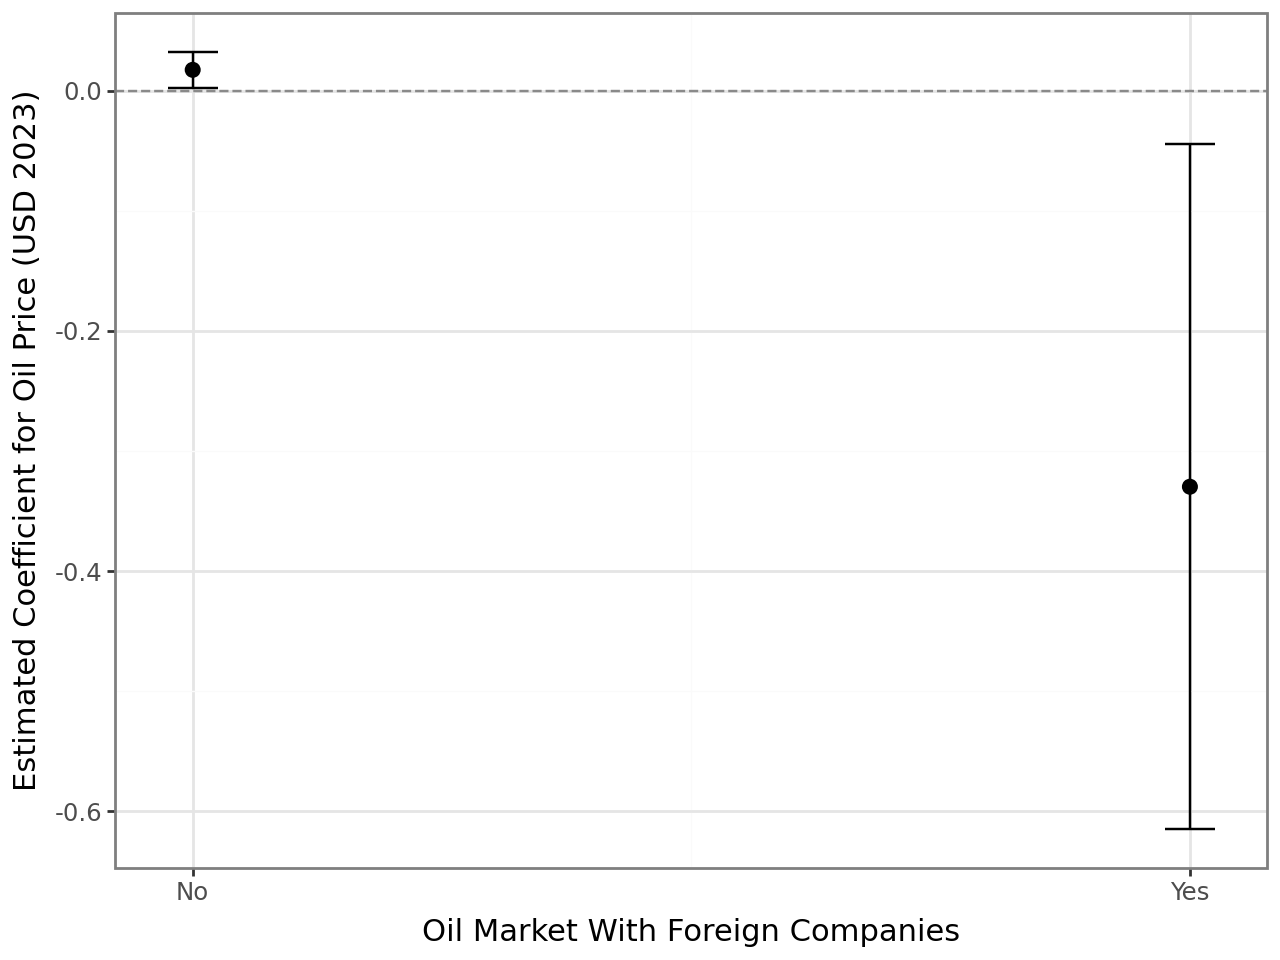

In [125]:
values = X.ForComp.unique()
merg_effect = models_zigp[0].params.iloc[1] + models_zigp[0].params.iloc[11] * values # 1 и 11 # 13 и 23
cov_m = np.asmatrix(models_zigp[0].cov_params())
se = (cov_m[1,1] + values**2*(cov_m[1,11]) + 2*values*cov_m[11,11])**(.5)

data_illustration = pd.DataFrame({'Foreign private company in the market': values,
                                  'ME': merg_effect,
                                  'error': norm.ppf(0.95) * se})
plot = (ggplot(data_illustration, aes(x='Foreign private company in the market',y='ME')) +
        geom_point(color='k',shape='.',size=5) +
        geom_errorbar(aes(ymin='ME-error',ymax='ME+error'),width=0.05,color='k',size=0.5) + 
        geom_hline(yintercept=0, linetype='dashed', color='k',alpha=0.4) +
        labs(#title="Marginal Effect of Oil Price (USD 2023) on Number of MIEs",
             y='Estimated Coefficient for Oil Price (USD 2023)',
             x='Oil Market With Foreign Companies') +
        scale_x_continuous(breaks=[0,1],labels=['No','Yes']) +
        theme_bw()
        )
plot

In [126]:
data = df[[
            'MIE(2)',
            'OilPrice',
            'ForComp',
            'LogGDPPC',
            'OilProduction',
            'Democracy',
            'RevolLeader',
            'Allies',
            'USTroops',
            'Rivalries',
            'Rebels',
            'Country',
            'Year'
    ]].dropna()
data['Interaction'] = data['OilPrice']*data['ForComp']

y = data['MIE(2)']
X = data.drop(columns=['MIE(2)','Country','Year'])
X = sm.add_constant(X)

m_zigp = ZeroInflatedGeneralizedPoisson(y,X,X)
m_zigp = m_zigp.fit(maxiter=10000,cov_type='HC3',method='lbfgs')

# получим ковариационную матрицу
variance_covariance = m_zigp.cov_params().iloc[12:24,12:24].values
params = m_zigp.params[12:24].values
coef_distribution = np.random.multivariate_normal(params, variance_covariance, size=10000)

# определим тип переменных
binary = ['RevolLeader']
categorical = ['Allies','Rivalries','Rebels']
continuous = ['LogGDPPC','OilProduction','Democracy','USTroops']

data_illustration = X[['const','OilPrice','ForComp','LogGDPPC','OilProduction','Democracy','RevolLeader','Allies','USTroops','Rivalries','Rebels','Interaction']].copy()

# определим диапазон переменной OilPrice
oil_range = list(range(10,141,10))
results = []

# определим y_pred для стран с ForComp = 0 и стран с ForComp = 1
for forcomp_val in [0,1]:
    for oil in oil_range:
        row = {}

        row['const'] = 1
        row['OilPrice'] = oil
        row['ForComp'] = forcomp_val
        row['Interaction'] = oil*forcomp_val

        for x in binary:
            row[x] = 1 if data_illustration[x].mean() >= 0.5 else 0

        for x in categorical:
            row[x] = data_illustration[x].mode().iloc[0]

        for x in continuous:
            row[x] = data_illustration[x].mean()

        # определим строку, как одномерный массив
        X_row = np.array([row[col] for col in data_illustration.columns])

        scores = np.exp(np.dot(X_row, coef_distribution.T)) # np.exp или expit

        results.append({
            'OilPrice': oil,
            'Predicted': np.mean(scores),
            'Lower': np.percentile(scores, 2.5),
            'Upper': np.percentile(scores, 97.5),
            'ForComp': forcomp_val
        })

# собираем результаты в датафрейм
df_plot = pd.DataFrame(results)
df_plot['ForComp'] = df_plot['ForComp'].map({0: 'Market Without Foreign Companies', 1: 'Market With Foreign Companies'})

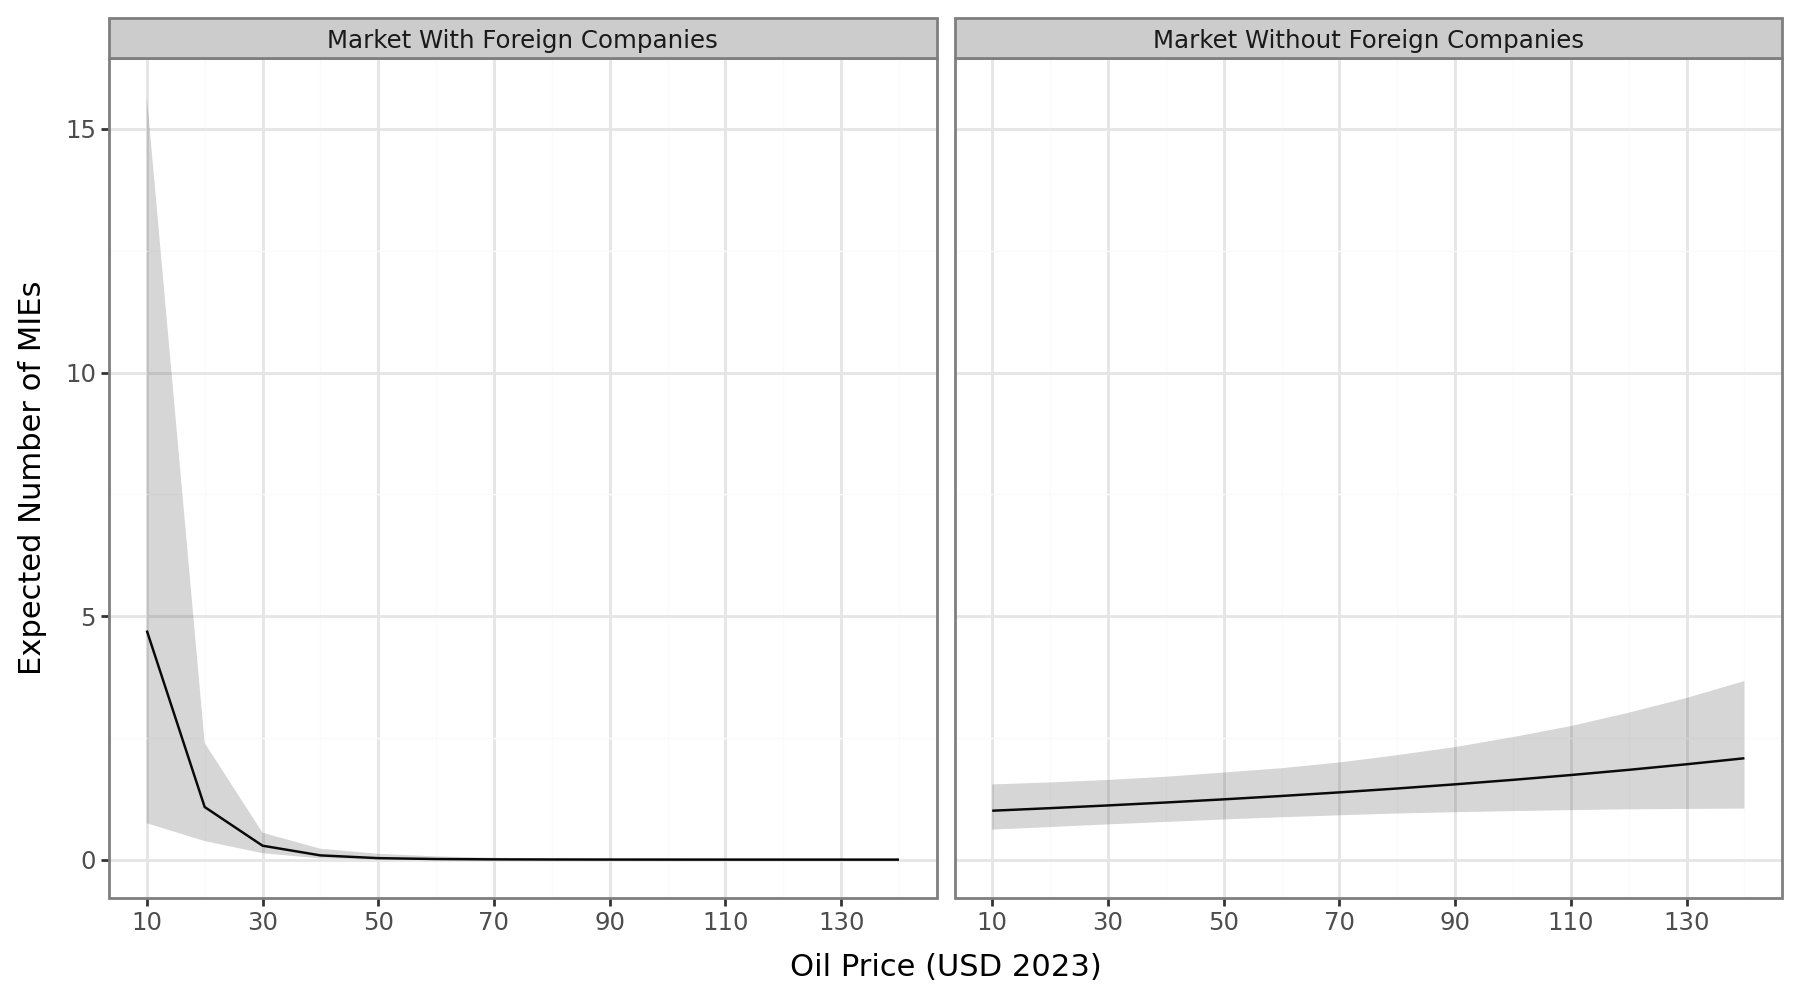

In [128]:
# facet-график

plot_facet = (
    ggplot(df_plot, aes(x='OilPrice',y='Predicted')) +
    geom_line(color='black') +
    geom_ribbon(aes(ymin='Lower',ymax='Upper'),alpha=0.2) +
    facet_wrap('~ForComp') +
    theme_bw() +
    labs(
        x='Oil Price (USD 2023)',
        y='Expected Number of MIEs'
    ) +
    scale_x_continuous(breaks=range(10,141,20)) +
    theme(figure_size = (9,5))
)
plot_facet

##### Zero Inflated Negative Binomial

In [129]:
# ZINB, init, interaction_term, without FE

models_zinb = []

for dep_variable in ['MIE(2)','MIE(4)']:
    for indep_variable in ['OilPrice','LagOilPrice','OilPriceAvg.3','OilPriceAvg.5']:

        data = df[[
            dep_variable,
            indep_variable,
            'ForComp',
            'LogGDPPC',
            'OilProduction',
            'Democracy',
            'RevolLeader',
            'Allies',
            'USTroops',
            'Rivalries',
            'Rebels',
            'Country',
            'Year'
            ]].dropna()
        data['Interaction'] = data[indep_variable]*data['ForComp']

        y = data[dep_variable]
        X = data.drop(columns=[dep_variable,'Country','Year'])
        X = sm.add_constant(X)

        if dep_variable == 'MIE(4)' and indep_variable == 'OilPriceAvg.3':
            m_zinb = ZeroInflatedNegativeBinomialP(y,X,X)
            m_zinb = m_zinb.fit(maxiter=100000,cov_type='HC3',method='bfgs')
            models_zinb.append(m_zinb)        
        else:
            m_zinb = ZeroInflatedNegativeBinomialP(y,X,X)
            m_zinb = m_zinb.fit(maxiter=100000,cov_type='HC3',method='lbfgs')
            models_zinb.append(m_zinb)

print(
    summary_col(
        [models_zinb[0],models_zinb[1],models_zinb[2],models_zinb[3],models_zinb[4],models_zinb[5],models_zinb[6],models_zinb[7]],
        stars=True,
        model_names=['MIE(2)','MIE(2)','MIE(2)','MIE(2)','MIE(4)','MIE(4)','MIE(4)','MIE(4)'],
        info_dict={
            'N': lambda x: '{0:d}'.format(int(x.nobs)),
            'LLF': lambda x: '{:.3f}'.format(x.llf),\
            'Pseudo R-squared': lambda x: '{:.3f}'.format(1 - (x.llf / x.llnull))
        },
        regressor_order=[
            'inflate_OilPrice',
            'inflate_LagOilPrice',
            'inflate_OilPriceAvg.3',
            'inflate_OilPriceAvg.5',
            'inflate_ForComp',
            'inflate_Interaction',
            'inflate_LogGDPPC',
            'inflate_OilProduction',
            'inflate_Democracy',
            'inflate_RevolLeader',
            'inflate_Allies',
            'inflate_USTroops',
            'inflate_Rivalries',
            'inflate_Rebels',
            'inflate_const',
            'OilPrice',
            'LagOilPrice',
            'OilPriceAvg.3',
            'OilPriceAvg.5',
            'ForComp',
            'Interaction',
            'LogGDPPC',
            'OilProduction',
            'Democracy',
            'RevolLeader',
            'Allies',
            'USTroops',
            'Rivalries',
            'Rebels',
            'const',
            'alpha'
        ]
    )
)

Optimization terminated successfully.
         Current function value: 1.126337
         Iterations: 157
         Function evaluations: 161
         Gradient evaluations: 161

                       MIE(2) I  MIE(2) II  MIE(2) III MIE(2) IIII  MIE(4) I  MIE(4) II  MIE(4) III MIE(4) IIII
---------------------------------------------------------------------------------------------------------------
inflate_OilPrice      0.0226*                                      0.0226*                                     
                      (0.0123)                                     (0.0123)                                    
inflate_LagOilPrice              0.0248*                                      0.0248*                          
                                 (0.0128)                                     (0.0128)                         
inflate_OilPriceAvg.3                       0.0291**                                     0.0297**              
                                        

#### Проверка на робастность (Fixed Effects)

Теперь мы включим в модель фиксированные эффекты на страны и десятилетия, которые позволят нам проконтролировать ненаблюдаемые факторы, не изменяемые во времени (FE на страны) и в пространстве (FE на десятилетия). Например, к первым можно отнести культурные особенности той или иной страны, а ко вторым макроэкономические факторы, свойственные определенным временным периодам.

In [130]:
data = df[[
    'MIE(2)',
    'OilPrice',
    'ForComp',
    'LogGDPPC',
    'OilProduction',
    'Democracy',
    'RevolLeader',
    'Allies',
    'USTroops',
    'Rivalries',
    'Rebels',
    'Country',
    'Year'
    ]].dropna()
data['Interaction'] = data['OilPrice']*data['ForComp']

df_dummies = pd.get_dummies(data['Country'],drop_first=True).astype(int)
data = pd.concat([data, df_dummies],axis=1)
data['decade'] = (data['Year'] // 10) * 10
df_dummies = pd.get_dummies(data['decade'], prefix='decade', drop_first=True).astype(int)
data = pd.concat([data, df_dummies], axis=1)
data.drop(columns=['decade'], inplace=True)

y = data['MIE(2)']
X = data.drop(columns=['MIE(2)','Country','Year'])
X = sm.add_constant(X)

m_zigp = ZeroInflatedGeneralizedPoisson(y,X,X)
m_zigp = m_zigp.fit(maxiter=50000,cov_type='HC3',method='lbfgs')
print(m_zigp.summary())

c:\Users\ESolodov\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available


                    ZeroInflatedGeneralizedPoisson Regression Results                     
Dep. Variable:                             MIE(2)   No. Observations:                  635
Model:             ZeroInflatedGeneralizedPoisson   Df Residuals:                      601
Method:                                       MLE   Df Model:                           33
Date:                            Sat, 17 May 2025   Pseudo R-squ.:                  0.2422
Time:                                    02:29:58   Log-Likelihood:                -661.07
converged:                                   True   LL-Null:                       -872.39
Covariance Type:                              HC3   LLR p-value:                 3.806e-69
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
inflate_const                   -1.3336      8.760     -0.152      0.879     -

Обратите внимание, что statsmodels выдает предупреждение `HessianInversionWarning`. Это означает, что во время обучения модели возникли проблемы с инверсией матрицы. Несмотря на то что в самой регрессионной выдаче в графе converged стоит True мы не можем быть уверены, что оценки коэффициентов оценены корректно.

Эта проблема может быть связана с тем, что в текущей спецификации модели очень большое количество переменных (напомним, что все переменные дублируются для каждой из компонент модели) по отношению к числу наблюдений. Также проблема может быть связана с вырождением матрицы, которое является следствием мультиколлинеарности.

И правда, как мы можем видеть, переменные `LogGFPPC`, `OilProduction`, `Democracy`, `Allies`, `Rivalries` имеют очень большие значение показателя VIF. Для того чтобы разрешить проблему мультиколлинеарности мы можем исключить из модели переменные с высоким показателем VIF, исключить фиксированные эффекты на страны (проверил, именно они ответственны за появление этой проблемы) или сформировать на основе сильно коррелированных переменных главные компоненты (проверил, это не очень помогает, так как мультиколлинеарность полностью не исчезает, даже если декомпозировать все до одной компоненты).

Далее реализуем сценарий с фиксированными эффектами на десятилетия.

In [131]:
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                 Feature         VIF
0                  const  176.671818
1               OilPrice    2.500323
2                ForComp    7.913302
3               LogGDPPC   38.200632
4          OilProduction   15.301746
5              Democracy   17.325031
6            RevolLeader    3.589541
7                 Allies   11.975224
8               USTroops    2.697269
9              Rivalries   11.102056
10                Rebels    2.199726
11           Interaction    4.339454
12                Angola    3.499349
13            Azerbaijan    2.942187
14                 Congo    7.202439
15                 Egypt    6.309182
16                 Gabon    5.598277
17                  Iran    5.342640
18                  Iraq    7.249575
19            Kazakhstan    8.875044
20                Kuwait    6.376675
21                 Libya    4.093569
22               Nigeria    6.905965
23                  Oman    3.574573
24                 Qatar    9.279188
25          Saudi Arabia    6.336732
2

##### Zero Inflated Generalized Poisson

In [132]:
# ZIGP, init, interaction_term, FE

models_zigp = []

for dep_variable in ['MIE(2)','MIE(4)']:
    for indep_variable in ['OilPrice','LagOilPrice','OilPriceAvg.3','OilPriceAvg.5']:

        data = df[[
            dep_variable,
            indep_variable,
            'LogGDPPC',
            'OilProduction',
            'Democracy',
            'RevolLeader',
            'Allies',
            'USTroops',
            'Rivalries',
            'Rebels',
            'ForComp',
            'Country',
            'Year'
            ]].dropna()
        data['Interaction'] = data[indep_variable]*data['ForComp']

        data['decade'] = (data['Year'] // 10) * 10
        df_dummies = pd.get_dummies(data['decade'], prefix='decade', drop_first=True).astype(int)
        data = pd.concat([data, df_dummies], axis=1)
        data.drop(columns=['decade'], inplace=True)

        y = data[dep_variable]
        X = data.drop(columns=[dep_variable,'Country','Year'])
        X = sm.add_constant(X)

        m_zigp = ZeroInflatedNegativeBinomialP(y,X,X)
        m_zigp = m_zigp.fit(maxiter=100000,cov_type='HC3',method='lbfgs')
        models_zigp.append(m_zigp)

print(
    summary_col(
        [models_zigp[0],models_zigp[1],models_zigp[2],models_zigp[3],models_zigp[4],models_zigp[5],models_zigp[6],models_zigp[7]],
        stars=True,
        model_names=['MIE(2)','MIE(2)','MIE(2)','MIE(2)','MIE(4)','MIE(4)','MIE(4)','MIE(4)'],
        info_dict={
            'N': lambda x: '{0:d}'.format(int(x.nobs)),
            'LLF': lambda x: '{:.3f}'.format(x.llf),\
            'Pseudo R-squared': lambda x: '{:.3f}'.format(1 - (x.llf / x.llnull))
        },
        regressor_order=[
            'inflate_OilPrice',
            'inflate_LagOilPrice',
            'inflate_OilPriceAvg.3',
            'inflate_OilPriceAvg.5',
            'inflate_ForComp',
            'inflate_Interaction',
            'inflate_LogGDPPC',
            'inflate_OilProduction',
            'inflate_Democracy',
            'inflate_RevolLeader',
            'inflate_Allies',
            'inflate_USTroops',
            'inflate_Rivalries',
            'inflate_Rebels',
            'inflate_const',
            'OilPrice',
            'LagOilPrice',
            'OilPriceAvg.3',
            'OilPriceAvg.5',
            'ForComp',
            'Interaction',
            'LogGDPPC',
            'OilProduction',
            'Democracy',
            'RevolLeader',
            'Allies',
            'USTroops',
            'Rivalries',
            'Rebels',
            'const',
            'alpha'
        ]
    )
)


                       MIE(2) I  MIE(2) II  MIE(2) III MIE(2) IIII  MIE(4) I  MIE(4) II  MIE(4) III MIE(4) IIII
---------------------------------------------------------------------------------------------------------------
inflate_OilPrice      0.0083                                       0.0083                                      
                      (0.0104)                                     (0.0104)                                    
inflate_LagOilPrice              0.0070                                       0.0070                           
                                 (0.0113)                                     (0.0113)                         
inflate_OilPriceAvg.3                       0.0084                                       0.0084                
                                            (0.0130)                                     (0.0130)              
inflate_OilPriceAvg.5                                  0.0099                                       0.0

##### Zero Inflated Negative Binomial

In [133]:
# ZINB, init, interaction_term, FE

models_zigp = []

for dep_variable in ['MIE(2)','MIE(4)']:
    for indep_variable in ['OilPrice','LagOilPrice','OilPriceAvg.3','OilPriceAvg.5']:

        data = df[[
            dep_variable,
            indep_variable,
            'LogGDPPC',
            'OilProduction',
            'Democracy',
            'RevolLeader',
            'Allies',
            'USTroops',
            'Rivalries',
            'Rebels',
            'ForComp',
            'Country',
            'Year'
            ]].dropna()
        data['Interaction'] = data[indep_variable]*data['ForComp']

        data['decade'] = (data['Year'] // 10) * 10
        df_dummies = pd.get_dummies(data['decade'], prefix='decade', drop_first=True).astype(int)
        data = pd.concat([data, df_dummies], axis=1)
        data.drop(columns=['decade'], inplace=True)

        y = data[dep_variable]
        X = data.drop(columns=[dep_variable,'Country','Year'])
        X = sm.add_constant(X)

        if (dep_variable == 'MIE(2)' and indep_variable == 'OilPriceAvg.5') or (dep_variable == 'MIE(4)' and indep_variable == 'OilPriceAvg.3'):
            m_zigp = ZeroInflatedNegativeBinomialP(y,X,X)
            m_zigp = m_zigp.fit(maxiter=100000,cov_type='HC3',method='bfgs')
            models_zigp.append(m_zigp)

        elif dep_variable == 'MIE(4)' and indep_variable == 'OilPrice':
            m_zigp = ZeroInflatedNegativeBinomialP(y,X,X)
            m_zigp = m_zigp.fit(maxiter=100000,cov_type='HC3',method='ncg')
            models_zigp.append(m_zigp)       

        else:
            m_zigp = ZeroInflatedNegativeBinomialP(y,X,X)
            m_zigp = m_zigp.fit(maxiter=100000,cov_type='HC3',method='lbfgs')
            models_zigp.append(m_zigp)

print(
    summary_col(
        [models_zigp[0],models_zigp[1],models_zigp[2],models_zigp[3],models_zigp[4],models_zigp[5],models_zigp[6],models_zigp[7]],
        stars=True,
        model_names=['MIE(2)','MIE(2)','MIE(2)','MIE(2)','MIE(4)','MIE(4)','MIE(4)','MIE(4)'],
        info_dict={
            'N': lambda x: '{0:d}'.format(int(x.nobs)),
            'LLF': lambda x: '{:.3f}'.format(x.llf),\
            'Pseudo R-squared': lambda x: '{:.3f}'.format(1 - (x.llf / x.llnull))
        },
        regressor_order=[
            'inflate_OilPrice',
            'inflate_LagOilPrice',
            'inflate_OilPriceAvg.3',
            'inflate_OilPriceAvg.5',
            'inflate_ForComp',
            'inflate_Interaction',
            'inflate_LogGDPPC',
            'inflate_OilProduction',
            'inflate_Democracy',
            'inflate_RevolLeader',
            'inflate_Allies',
            'inflate_USTroops',
            'inflate_Rivalries',
            'inflate_Rebels',
            'inflate_const',
            'OilPrice',
            'LagOilPrice',
            'OilPriceAvg.3',
            'OilPriceAvg.5',
            'ForComp',
            'Interaction',
            'LogGDPPC',
            'OilProduction',
            'Democracy',
            'RevolLeader',
            'Allies',
            'USTroops',
            'Rivalries',
            'Rebels',
            'const',
            'alpha'
        ]
    )
)

Optimization terminated successfully.
         Current function value: 1.113965
         Iterations: 232
         Function evaluations: 236
         Gradient evaluations: 236
Optimization terminated successfully.
         Current function value: 1.109163
         Iterations: 35
         Function evaluations: 51
         Gradient evaluations: 51
         Hessian evaluations: 35
Optimization terminated successfully.
         Current function value: 1.110321
         Iterations: 234
         Function evaluations: 238
         Gradient evaluations: 238

                       MIE(2) I  MIE(2) II  MIE(2) III MIE(2) IIII  MIE(4) I  MIE(4) II  MIE(4) III MIE(4) IIII
---------------------------------------------------------------------------------------------------------------
inflate_OilPrice      0.0083                                       0.0086                                      
                      (0.0104)                                     (0.0106)                                 

##### Проверка на мультиколлинеарность

In [134]:
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

          Feature        VIF
0           const  31.391582
1   OilPriceAvg.5   3.778739
2        LogGDPPC   1.613960
3   OilProduction   2.084962
4       Democracy   1.310778
5     RevolLeader   1.825892
6          Allies   1.141367
7        USTroops   1.760605
8       Rivalries   2.103042
9          Rebels   1.504562
10        ForComp   5.116712
11    Interaction   4.134903
12    decade_1970   3.438100
13    decade_1980   6.904421
14    decade_1990   4.183808
15    decade_2000   3.146050


### Тестирование Гипотезы 2

##### Zero Inflated Generalized Poisson

In [135]:
data = df[[
    'MIE(2)_against',
    'OilPrice',
    'LogGDPPC',
    'OilProduction',
    'Democracy',
    'RevolLeader',
    'Allies',
    'USTroops',
    'Rivalries',
    'Rebels',
    'ForComp',
    'Country',
    'Year'
    ]].dropna()
data['Interaction'] = data['OilPrice']*data['ForComp']

y = data['MIE(2)_against']
X = data.drop(columns=['MIE(2)_against','Country','Year'])
X = sm.add_constant(X)

m_zigp = ZeroInflatedGeneralizedPoisson(y,X,X)
m_zigp = m_zigp.fit(maxiter=10000,cov_type='HC3',method='lbfgs')
print(m_zigp.summary())

                    ZeroInflatedGeneralizedPoisson Regression Results                     
Dep. Variable:                     MIE(2)_against   No. Observations:                  635
Model:             ZeroInflatedGeneralizedPoisson   Df Residuals:                      623
Method:                                       MLE   Df Model:                           11
Date:                            Sat, 17 May 2025   Pseudo R-squ.:                  0.1190
Time:                                    02:30:58   Log-Likelihood:                -819.48
converged:                                   True   LL-Null:                       -930.18
Covariance Type:                              HC3   LLR p-value:                 2.658e-41
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
inflate_const             0.9439      0.907      1.040      0.298      -0.834       2.722
in

##### Проверка результатов на робастность

##### Zero Inflated Generalized Poisson

In [136]:
# ZIGP, against, interaction_term, without FE

models_zigp = []

for dep_variable in ['MIE(2)_against','MIE(4)_against']:
    for indep_variable in ['OilPrice','LagOilPrice','OilPriceAvg.3','OilPriceAvg.5']:

        data = df[[
            dep_variable,
            indep_variable,
            'ForComp',
            'LogGDPPC',
            'OilProduction',
            'Democracy',
            'RevolLeader',
            'Allies',
            'USTroops',
            'Rivalries',
            'Rebels',
            'Country',
            'Year'
            ]].dropna()
        data['Interaction'] = data[indep_variable]*data['ForComp']

        y = data[dep_variable]
        X = data.drop(columns=[dep_variable,'Country','Year'])
        X = sm.add_constant(X)

        m_zigp = ZeroInflatedGeneralizedPoisson(y,X,X)
        m_zigp = m_zigp.fit(maxiter=10000,cov_type='HC3',method='lbfgs')
        models_zigp.append(m_zigp)

print(
    summary_col(
        [models_zigp[0],models_zigp[1],models_zigp[2],models_zigp[3],models_zigp[4],models_zigp[5],models_zigp[6],models_zigp[7]],
        stars=True,
        model_names=['MIE(2)','MIE(2)','MIE(2)','MIE(2)','MIE(4)','MIE(4)','MIE(4)','MIE(4)'],
        info_dict={
            'N': lambda x: '{0:d}'.format(int(x.nobs)),
            'LLF': lambda x: '{:.3f}'.format(x.llf),\
            'Pseudo R-squared': lambda x: '{:.3f}'.format(1 - (x.llf / x.llnull))
        },
        regressor_order=[
            'inflate_OilPrice',
            'inflate_LagOilPrice',
            'inflate_OilPriceAvg.3',
            'inflate_OilPriceAvg.5',
            'inflate_ForComp',
            'inflate_Interaction',
            'inflate_LogGDPPC',
            'inflate_OilProduction',
            'inflate_Democracy',
            'inflate_RevolLeader',
            'inflate_Allies',
            'inflate_USTroops',
            'inflate_Rivalries',
            'inflate_Rebels',
            'inflate_const',
            'OilPrice',
            'LagOilPrice',
            'OilPriceAvg.3',
            'OilPriceAvg.5',
            'ForComp',
            'Interaction',
            'LogGDPPC',
            'OilProduction',
            'Democracy',
            'RevolLeader',
            'Allies',
            'USTroops',
            'Rivalries',
            'Rebels',
            'const',
            'alpha'
        ]
    )
)


                       MIE(2) I  MIE(2) II  MIE(2) III MIE(2) IIII  MIE(4) I  MIE(4) II  MIE(4) III MIE(4) IIII
---------------------------------------------------------------------------------------------------------------
inflate_OilPrice      -0.0013                                      -0.0013                                     
                      (0.0065)                                     (0.0065)                                    
inflate_LagOilPrice              -0.0076                                      -0.0076                          
                                 (0.0071)                                     (0.0071)                         
inflate_OilPriceAvg.3                       -0.0075                                      -0.0075               
                                            (0.0083)                                     (0.0083)              
inflate_OilPriceAvg.5                                  -0.0158                                      -0.

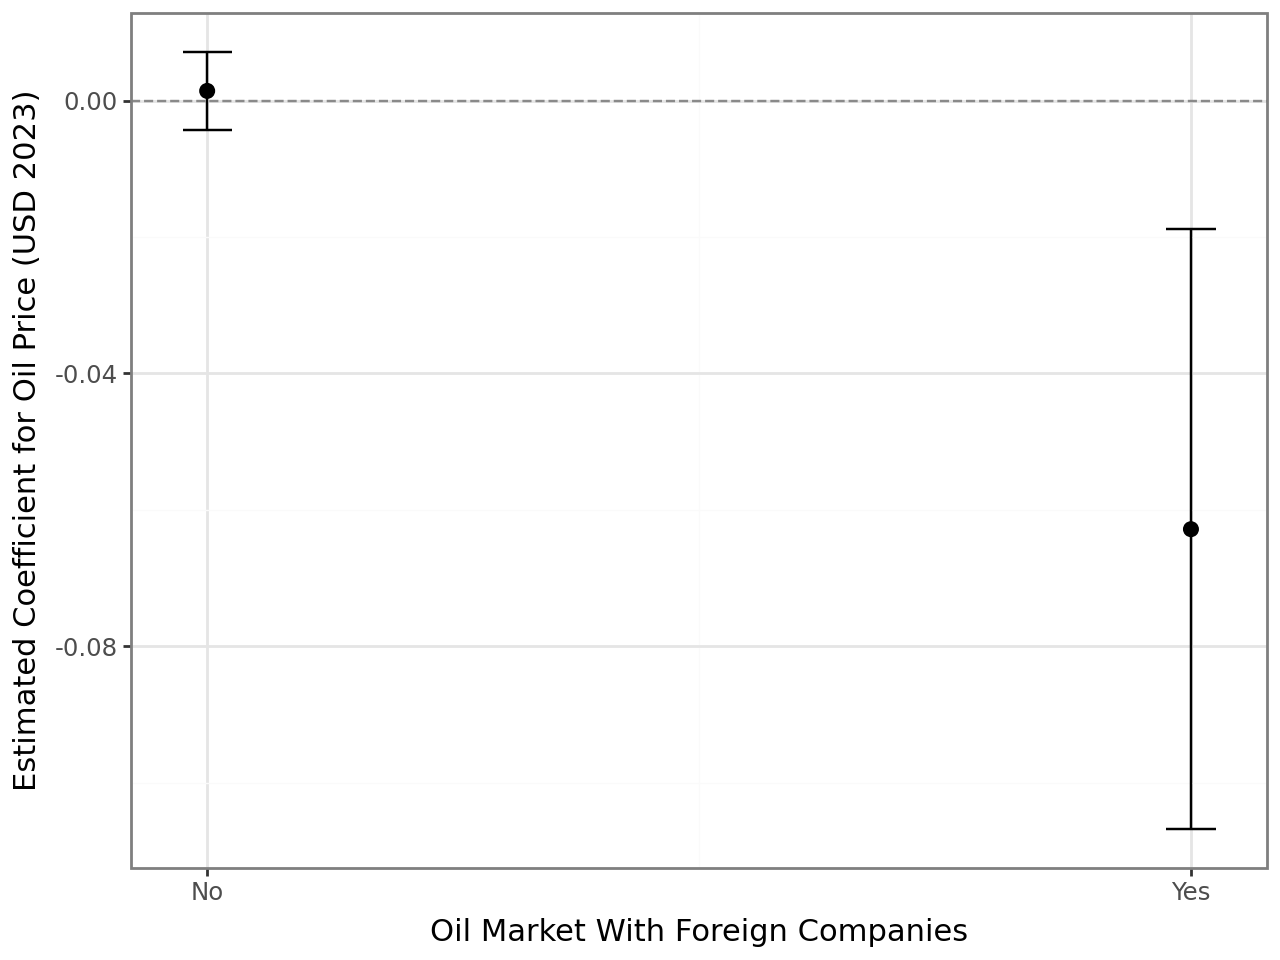

In [137]:
values = X.ForComp.unique()
merg_effect = models_zigp[0].params.iloc[13] + models_zigp[0].params.iloc[23] * values
cov_m = np.asmatrix(models_zigp[0].cov_params())
se = (cov_m[13,13] + values**2*(cov_m[23,23]) + 2*values*cov_m[13,23])**(.5)

data_illustration = pd.DataFrame({'Foreign private company in the market': values,
                                  'ME': merg_effect,
                                  'error': norm.ppf(0.95) * se})
plot = (ggplot(data_illustration, aes(x='Foreign private company in the market',y='ME')) +
        geom_point(color='k',shape='.',size=5) +
        geom_errorbar(aes(ymin='ME-error',ymax='ME+error'),width=0.05,color='k',size=0.5) + 
        geom_hline(yintercept=0, linetype='dashed', color='k',alpha=0.4) +
        labs(#title="Marginal Effect of Oil Price (USD 2023) on Number of MIEs",
             y='Estimated Coefficient for Oil Price (USD 2023)',
             x='Oil Market With Foreign Companies') +
        scale_x_continuous(breaks=[0,1],labels=['No','Yes']) +
        theme_bw()
        )
plot

In [138]:
data = df[[
            'MIE(2)_against',
            'OilPrice',
            'ForComp',
            'LogGDPPC',
            'OilProduction',
            'Democracy',
            'RevolLeader',
            'Allies',
            'USTroops',
            'Rivalries',
            'Rebels',
            'Country',
            'Year'
    ]].dropna()
data['Interaction'] = data['OilPrice']*data['ForComp']

y = data['MIE(2)_against']
X = data.drop(columns=['MIE(2)_against','Country','Year'])
X = sm.add_constant(X)

m_zigp = ZeroInflatedGeneralizedPoisson(y,X,X)
m_zigp = m_zigp.fit(maxiter=10000,cov_type='HC3',method='lbfgs')

# получим ковариационную матрицу
variance_covariance = m_zigp.cov_params().iloc[12:24,12:24].values
params = m_zigp.params[12:24].values
coef_distribution = np.random.multivariate_normal(params, variance_covariance, size=10000)

# определим тип переменных
binary = ['RevolLeader']
categorical = ['Allies','Rivalries','Rebels']
continuous = ['LogGDPPC','OilProduction','Democracy','USTroops']

data_illustration = X[['const','OilPrice','ForComp','LogGDPPC','OilProduction','Democracy','RevolLeader','Allies','USTroops','Rivalries','Rebels','Interaction']].copy()

# определим диапазон переменной OilPrice
oil_range = list(range(10,141,10))
results = []

# определим y_pred для стран с ForComp = 0 и стран с ForComp = 1
for forcomp_val in [0,1]:
    for oil in oil_range:
        row = {}

        row['const'] = 1
        row['OilPrice'] = oil
        row['ForComp'] = forcomp_val
        row['Interaction'] = oil*forcomp_val

        for x in binary:
            row[x] = 1 if data_illustration[x].mean() >= 0.5 else 0

        for x in categorical:
            row[x] = data_illustration[x].mode().iloc[0]

        for x in continuous:
            row[x] = data_illustration[x].mean()

        # определим строку, как одномерный массив
        X_row = np.array([row[col] for col in data_illustration.columns])

        scores = np.exp(np.dot(X_row, coef_distribution.T)) # np.exp или expit

        results.append({
            'OilPrice': oil,
            'Predicted': np.mean(scores),
            'Lower': np.percentile(scores, 2.5),
            'Upper': np.percentile(scores, 97.5),
            'ForComp': forcomp_val
        })

# собираем результаты в датафрейм
df_plot = pd.DataFrame(results)
df_plot['ForComp'] = df_plot['ForComp'].map({0: 'Market Without Foreign Companies', 1: 'Market With Foreign Companies'})

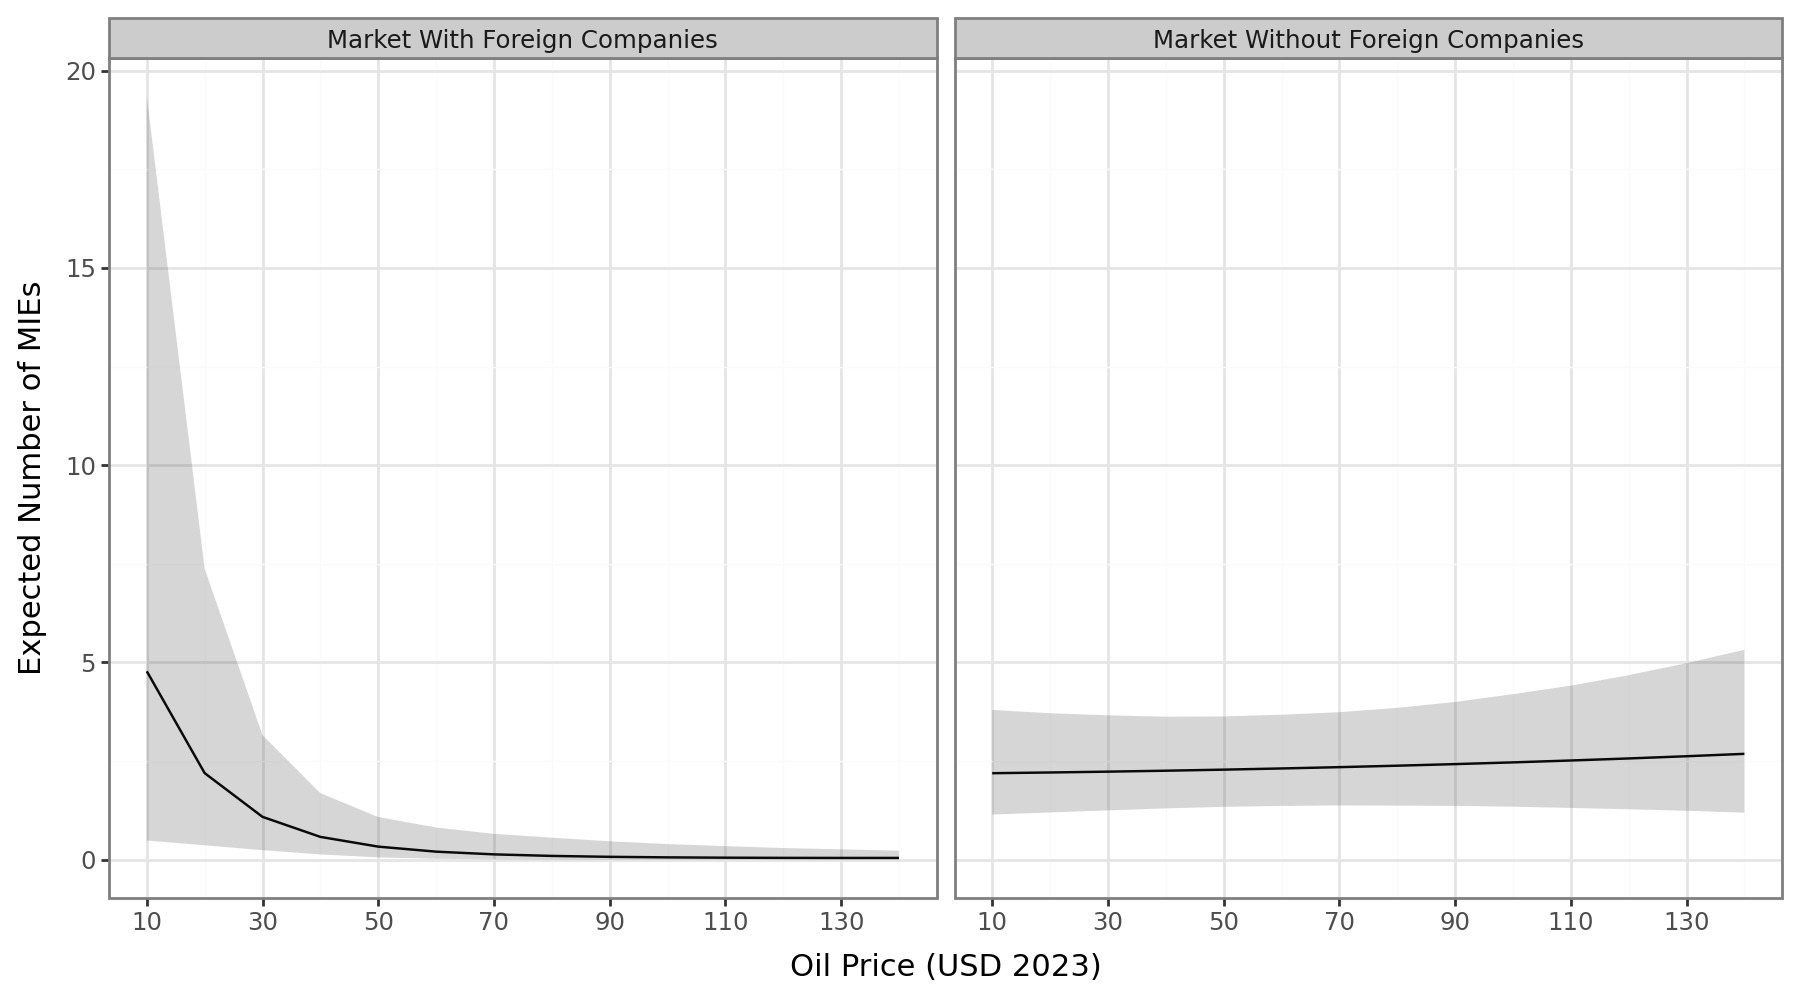

In [139]:
# facet-график

plot_facet = (
    ggplot(df_plot, aes(x='OilPrice',y='Predicted')) +
    geom_line(color='black') +
    geom_ribbon(aes(ymin='Lower',ymax='Upper'),alpha=0.2) +
    facet_wrap('~ForComp') +
    theme_bw() +
    labs(
        x='Oil Price (USD 2023)',
        y='Expected Number of MIEs'
    ) +
    scale_x_continuous(breaks=range(10,141,20)) +
    theme(figure_size = (9,5))
)
plot_facet

##### Проверка результатов на робастность (Fixed Effects)

##### Zero Inflated Generalized Poisson

In [140]:
# ZIGP, against, interaction_term, FE

models_zigp = []

for dep_variable in ['MIE(2)_against','MIE(4)_against']:
    for indep_variable in ['OilPrice','LagOilPrice','OilPriceAvg.3','OilPriceAvg.5']:

        data = df[[
            dep_variable,
            indep_variable,
            'ForComp',
            'LogGDPPC',
            'OilProduction',
            'Democracy',
            'RevolLeader',
            'Allies',
            'USTroops',
            'Rivalries',
            'Rebels',
            'Country',
            'Year'
            ]].dropna()
        data['Interaction'] = data[indep_variable]*data['ForComp']

        data['decade'] = (data['Year'] // 10) * 10
        df_dummies = pd.get_dummies(data['decade'], prefix='decade', drop_first=True).astype(int)
        data = pd.concat([data, df_dummies], axis=1)
        data.drop(columns=['decade'], inplace=True)

        y = data[dep_variable]
        X = data.drop(columns=[dep_variable,'Country','Year'])
        X = sm.add_constant(X)

        m_zigp = ZeroInflatedGeneralizedPoisson(y,X,X)
        m_zigp = m_zigp.fit(maxiter=10000,cov_type='HC3',method='lbfgs')
        models_zigp.append(m_zigp)

print(
    summary_col(
        [models_zigp[0],models_zigp[1],models_zigp[2],models_zigp[3],models_zigp[4],models_zigp[5],models_zigp[6],models_zigp[7]],
        stars=True,
        model_names=['MIE(2)','MIE(2)','MIE(2)','MIE(2)','MIE(4)','MIE(4)','MIE(4)','MIE(4)'],
        info_dict={
            'N': lambda x: '{0:d}'.format(int(x.nobs)),
            'LLF': lambda x: '{:.3f}'.format(x.llf),\
            'Pseudo R-squared': lambda x: '{:.3f}'.format(1 - (x.llf / x.llnull))
        },
        regressor_order=[
            'inflate_OilPrice',
            'inflate_LagOilPrice',
            'inflate_OilPriceAvg.3',
            'inflate_OilPriceAvg.5',
            'inflate_ForComp',
            'inflate_Interaction',
            'inflate_LogGDPPC',
            'inflate_OilProduction',
            'inflate_Democracy',
            'inflate_RevolLeader',
            'inflate_Allies',
            'inflate_USTroops',
            'inflate_Rivalries',
            'inflate_Rebels',
            'inflate_const',
            'OilPrice',
            'LagOilPrice',
            'OilPriceAvg.3',
            'OilPriceAvg.5',
            'ForComp',
            'Interaction',
            'LogGDPPC',
            'OilProduction',
            'Democracy',
            'RevolLeader',
            'Allies',
            'USTroops',
            'Rivalries',
            'Rebels',
            'const',
            'alpha'
        ]
    )
)


                       MIE(2) I  MIE(2) II  MIE(2) III MIE(2) IIII  MIE(4) I  MIE(4) II  MIE(4) III MIE(4) IIII
---------------------------------------------------------------------------------------------------------------
inflate_OilPrice      0.0088                                       0.0088                                      
                      (0.0083)                                     (0.0083)                                    
inflate_LagOilPrice              0.0077                                       0.0077                           
                                 (0.0114)                                     (0.0114)                         
inflate_OilPriceAvg.3                       0.0170                                       0.0170                
                                            (0.0177)                                     (0.0177)              
inflate_OilPriceAvg.5                                  0.0131                                       0.0

### Тестирование Гипотезы 3

Для того чтобы протестировать взаимосвязь между присутствием иностранных компаний в нефтедобывающей отрасли страны и риском завершения вооруженного конфликта, инициированного нефтедобывающей страной (или против этой страны) мы можем использовать модель пропорциональных рисков Кокса с изменяющейся во времени переменной. 

Эта модель основывается на трех ключевых предположениях: пропорциональность рисков (отношение рисков между наблюдениями не изменяется со временем), независимость наблюдений, линейная зависимость логарифма риска от переменных.

Функция риска для наблюдения $i$ в момент времени $t$ записывается следующим образом:

$$ h_i (t) = h_0 (t) e^{\left(\sum_{j}^{n} \beta_j x(t)_{ij} \right)},$$

где $h_0 (t)$ - базовая функция риска, общая для всех наблюдений, $x(t)$ - вектор значений изменяющейся во времени переменной в момент $t$.

In [50]:
df = pd.read_csv(r'C:\Users\ESolodov\Desktop\mine\df_res\export50_events_against.csv')

In [51]:
df = pd.DataFrame({
    'Country' : df['StateNme'],
    'Id' : df['id'],
    'Days' : df['days'],
    'Tstart' : df['tstart'],
    'Tstop' : df['tstop'],
    'Event' : df['event_y'],
    'OilPrice' : df['price2023'],
    'Democracy' : df['v2x_polyarchy'],
    'LogGDPPC' : df['log_gdppc'],       
    'OilProduction' : df['prod_yj'],
    'ForComp' : df['for_priv'],
    'RevolLeader' : df['revolutionaryleader'],
    'Rivalries' : df['miller'],
    'Allies' : df['number'],
    'Rebels' : df['nsa'],
    'USTroops' : df['troops_yj']
}).dropna()

#### Cox's proportional hazard model

In [52]:
data = df[[
    'Id',
    'Tstart',
    'Tstop',
    'Event',
    'OilPrice',
    'ForComp',
    'LogGDPPC',
    'OilProduction',
    'Democracy',
    'RevolLeader',
    'Allies',
    'USTroops',
    'Rivalries',
    'Rebels'
]].dropna()

ctv = CoxTimeVaryingFitter()
ctv.fit(data, id_col="Id", event_col="Event", start_col="Tstart", stop_col="Tstop", show_progress=True)
ctv.print_summary()

Iteration 1: norm_delta = 8.98e-01, step_size = 0.9500, log_lik = -779.07504, newton_decrement = 1.99e+01, seconds_since_start = 0.0
Iteration 2: norm_delta = 1.19e-01, step_size = 0.9500, log_lik = -761.45069, newton_decrement = 8.21e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 9.11e-03, step_size = 0.9500, log_lik = -760.62784, newton_decrement = 3.38e-03, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.06e-04, step_size = 1.0000, log_lik = -760.62447, newton_decrement = 9.20e-06, seconds_since_start = 0.0
Iteration 5: norm_delta = 7.57e-08, step_size = 1.0000, log_lik = -760.62446, newton_decrement = 1.48e-13, seconds_since_start = 0.0
Convergence completed after 5 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 6466 periods, 181 subjects, 184 events>
         event col = 'Event'
number of subjects = 181
 number of periods = 6466
  number of events = 184
partial log-likelihood = -760.62
  time fit was run = 2025-05-17 00:38:11 UTC

---
               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                      
OilPrice      -0.01      0.99      0.01           -0.03            0.01                0.97                1.01
ForComp        0.15      1.16      1.08           -1.98            2.27                0.14                9.68
LogGDPPC       0.04      1.04      0.14           -0.24            0.32                0.79                1.37
OilProduction -0.07      0.93      0.14           -0.35            0.21                0.70                1.24
Democracy      1.58      4.83      1.13           -0.65            3.80                0.52               44.61
RevolLeader   -0.43      0.65      0.31           -1.05            0.18                0.35                1.20
Allies         0.03      1.03      0.02           -0.00            0.06                1.00                1.06
USTroops      -0.40      0.67      0.10           -0.60           -0.20                0.55                0.82
Rivalries      0.17      1.18      0.06            0.04            0.29                1.04                1.34
Rebels        -0.34      0.71      0.10           -0.53           -0.15                0.59                0.86

               cmp to     z      p  -log2(p)
covariate                                   
OilPrice         0.00 -0.98   0.33      1.62
ForComp          0.00  0.13   0.89      0.16
LogGDPPC         0.00  0.29   0.77      0.37
OilProduction    0.00 -0.47   0.64      0.65
Democracy        0.00  1.39   0.16      2.60
RevolLeader      0.00 -1.37   0.17      2.56
Allies           0.00  1.76   0.08      3.67
USTroops         0.00 -3.94 <0.005     13.56
Rivalries        0.00  2.62   0.01      6.82
Rebels           0.00 -3.55 <0.005     11.36
---
Partial AIC = 1541.25
log-likelihood ratio test = 36.90 on 10 df
-log2(p) of ll-ratio test = 14.05

<Axes: xlabel='log(HR) (95% CI)'>

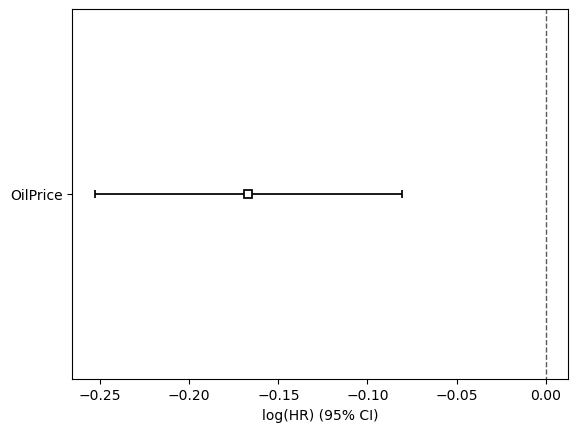

In [36]:
ctv.plot(columns=['OilPrice'])

### Тестирование Гипотезы 4

In [47]:
df = pd.read_csv(r'C:\Users\ESolodov\Desktop\mine\df_res\export50_events_against.csv')

In [48]:
df = pd.DataFrame({
    'Country' : df['StateNme'],
    'Id' : df['id'],
    'Days' : df['days'],
    'Tstart' : df['tstart'],
    'Tstop' : df['tstop'],
    'Event' : df['event_y'],
    'OilPrice' : df['price2023'],
    'Democracy' : df['v2x_polyarchy'],
    'LogGDPPC' : df['log_gdppc'],       
    'OilProduction' : df['prod_yj'],
    'ForComp' : df['for_priv'],
    'RevolLeader' : df['revolutionaryleader'],
    'Rivalries' : df['miller'],
    'Allies' : df['number'],
    'Rebels' : df['nsa'],
    'USTroops' : df['troops_yj']
}).dropna()

#### Cox's proportional hazard model

In [49]:
data = df[[
    'Id',
    'Tstart',
    'Tstop',
    'Event',
    'OilPrice',
    'ForComp',
    'LogGDPPC',
    'OilProduction',
    'Democracy',
    'RevolLeader',
    'Allies',
    'USTroops',
    'Rivalries',
    'Rebels'
]].dropna()

ctv = CoxTimeVaryingFitter()
ctv.fit(data, id_col="Id", event_col="Event", start_col="Tstart", stop_col="Tstop", show_progress=True)
ctv.print_summary()

Iteration 1: norm_delta = 8.98e-01, step_size = 0.9500, log_lik = -779.07504, newton_decrement = 1.99e+01, seconds_since_start = 0.0
Iteration 2: norm_delta = 1.19e-01, step_size = 0.9500, log_lik = -761.45069, newton_decrement = 8.21e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 9.11e-03, step_size = 0.9500, log_lik = -760.62784, newton_decrement = 3.38e-03, seconds_since_start = 0.0
Iteration 4: norm_delta = 5.06e-04, step_size = 1.0000, log_lik = -760.62447, newton_decrement = 9.20e-06, seconds_since_start = 0.0
Iteration 5: norm_delta = 7.57e-08, step_size = 1.0000, log_lik = -760.62446, newton_decrement = 1.48e-13, seconds_since_start = 0.0
Convergence completed after 5 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 6466 periods, 181 subjects, 184 events>
         event col = 'Event'
number of subjects = 181
 number of periods = 6466
  number of events = 184
partial log-likelihood = -760.62
  time fit was run = 2025-05-17 00:37:22 UTC

---
               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                      
OilPrice      -0.01      0.99      0.01           -0.03            0.01                0.97                1.01
ForComp        0.15      1.16      1.08           -1.98            2.27                0.14                9.68
LogGDPPC       0.04      1.04      0.14           -0.24            0.32                0.79                1.37
OilProduction -0.07      0.93      0.14           -0.35            0.21                0.70                1.24
Democracy      1.58      4.83      1.13           -0.65            3.80                0.52               44.61
RevolLeader   -0.43      0.65      0.31           -1.05            0.18                0.35                1.20
Allies         0.03      1.03      0.02           -0.00            0.06                1.00                1.06
USTroops      -0.40      0.67      0.10           -0.60           -0.20                0.55                0.82
Rivalries      0.17      1.18      0.06            0.04            0.29                1.04                1.34
Rebels        -0.34      0.71      0.10           -0.53           -0.15                0.59                0.86

               cmp to     z      p  -log2(p)
covariate                                   
OilPrice         0.00 -0.98   0.33      1.62
ForComp          0.00  0.13   0.89      0.16
LogGDPPC         0.00  0.29   0.77      0.37
OilProduction    0.00 -0.47   0.64      0.65
Democracy        0.00  1.39   0.16      2.60
RevolLeader      0.00 -1.37   0.17      2.56
Allies           0.00  1.76   0.08      3.67
USTroops         0.00 -3.94 <0.005     13.56
Rivalries        0.00  2.62   0.01      6.82
Rebels           0.00 -3.55 <0.005     11.36
---
Partial AIC = 1541.25
log-likelihood ratio test = 36.90 on 10 df
-log2(p) of ll-ratio test = 14.05

<Axes: xlabel='log(HR) (95% CI)'>

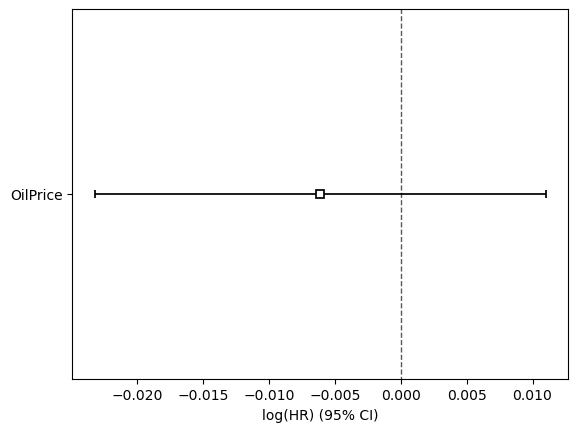

In [40]:
ctv.plot(columns=['OilPrice'])